# Logistic Regression

Logistic Regression is a simple yet effective model, and makes for a good baseline. We will use it to introduce the metrics and techniques used to deal with high class imbalance, and to check whether using a more sophisticated model (gradient boosted tree) later improves performance.

## Time Splits

When dealing with a time series, data needs to be split across time to preserve causality and avoid information leakage. A single compromised payment method will generate several fraudulent transactions. If those transactions find themselves both in the test and training datasets, performance will increase artificially and the model will not generalize well.   
  
Let demonstrate the trap of information leakage by training the model using two different time splits:  
-First one trains on 0-50% of the data and calibrates+tests on 70-100%  
-Second one trains on 20-70% of the data and calibrates+tests on 70-100%  
  
Though the training sample size is roughly the same, and test/calibration sets are identical, the 20-70 split performs substantially better as can be seen on the ROC and PR plots (see the Model Evaluation section). This advantage is misleading: as data from the second day can be found both in training and testing sets, the model leverages data leakage to make better predictions, but this improvement would on data that is truly new.  
  
This nicely demonstrates the necessity for a time buffer between training and testing data to avoid overly optimistic performance estimates. In our case, with two days of data we can only go so far, so we will stick with split 1 (training only day 1) for the remainder of this project.

In [52]:
## Data and libraries imports

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import plotly.graph_objects as go
import plotly.io as pio
#pio.renderers.default = "plotly-mimetype"
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from metrics import plot_cost_function, classify, compute_TPR, compute_precision
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("../data/raw.csv")



In [53]:

## Time split

maxTime = df["Time"].max()

df_train_1 = df[df["Time"].between(0 * maxTime, 0.5 * maxTime, inclusive='left')]
df_train_2 = df[df["Time"].between(0.2 * maxTime, 0.7 * maxTime, inclusive='left')]
df_cal = df[df["Time"].between(0.7 * maxTime, 0.85 * maxTime, inclusive='left')]
df_test = df[df["Time"] >= 0.85 * maxTime]

X_train_1 = df_train_1.drop(columns=["Class", "Time", "Amount"])
X_train_2 = df_train_2.drop(columns=["Class", "Time", "Amount"])
X_cal = df_cal.drop(columns=["Class", "Time", "Amount"])
X_test = df_test.drop(columns=["Class", "Time", "Amount"])

Y_train_1 = df_train_1["Class"]
Y_train_2 = df_train_2["Class"]
Y_test = df_test["Class"]
Y_cal = df_cal["Class"]

## Models

model_1 = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1
)

model_1.fit(X_train_1, Y_train_1)

model_2 = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1
)

model_2.fit(X_train_2, Y_train_2)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

## Model Evaluation

For problems with high class imbalance such as this one, accuracy alone is not apropriate. A simple classifier that flags all transactions as genuine would have an accuracy of 100 - 0.17 = 99.83%, but would be completely useless. A useful fraud detection model must achieve both a high recall (the proportion of positives correctly classified, also known as the True Positive Rate) **and** a high precision (the proportion of predicted positives that are actual positives).  
  
Precision and recall depend on the decision threshold. A model that outputs probability estimates typically applies a default threshold of 0.5. For highly imbalanced data however, the threshold needs to be chosen carefully (see the Threshold Selection section), as the low number of positives makes the trade-off between recall and precision critical.  

We can obtain threshold-independent metrics by plotting simple metrics for all threshold values:  
   
- The Receiver Operating Characteristic plots the True Positive Rate (or recall) against the False Positive Rate for all thresholds. A perfect classifier would achieve a TPR of 1 and a FPR of 0 for some threshold value, meaning the curve would go from (0,0) to (0,1) to then (1,1). For a random classifier, the probability for any sample to be classified as positive is equal to 1 - threshold, and so are both the TPR and the FPR. The curve would go from (0,0) to (1,1). For a real model, we can expect anything in between, but the closer we get to the perfect classifier the better.  
  
- The Precision-Recall curve plots the precision agaisnt the recall for all thresholds. A perfect classifier would achieve a precision of 1 and a recall of 1 for some threshold, so it would go from (0,1) to (1,1) to then (1,0). A random classifier would always have a precision equal to the prevalence rate, 0.0017 in our case, so the curve would go from (0, 0.0017) to (1, 0.0017). For a real model, we can expect anything in between, but the closer we get to the perfect classifier the better.  
  
Looking at the PR and ROC for our logistic regression models, we can note two things:  
- The model trained on the second time split performs a little better.  
- Both models demonstrate suspsiciously good performances overall. A sophisticated model trained on extensive data with well made feature engineering can expect to reach an AUC ROC of 0.9 and a AUC PR of 0.5. An AUC of .94 and of .70 for the ROC and PR curves respectively would rank our fraud detection model among the very best, but we should rather interpret those metrics as indication of our dataset's limitations. Indeed, fraud patterns are probably really similar across the two-days, and the model learns to recognize those specific patterns instead of what fraud might look like in general. For example, a card that was already seen as compromised on the training data and that made further fraudulent transactions on the testing data would artificially increase the performances.  
  
In any case, the metrics obtained for the logistic regression can serve as comparison for the gradient boosted tree we will train in the next chapter.

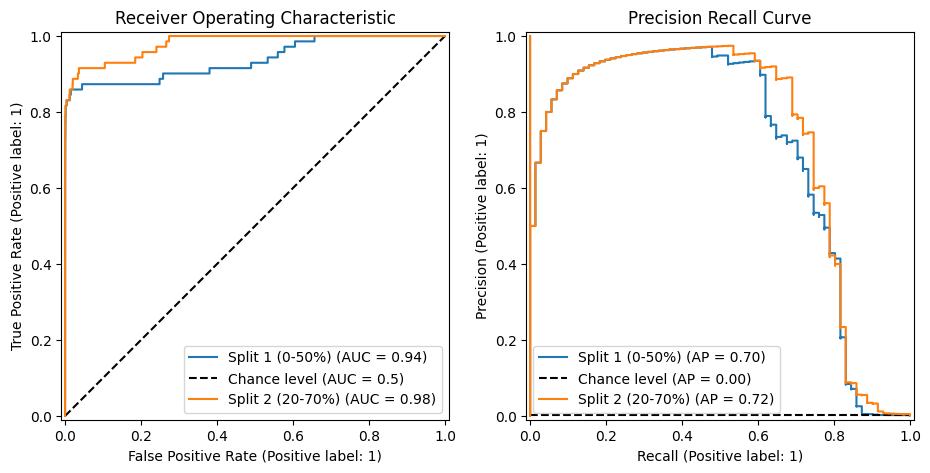

In [54]:
## Model evaluation: ROC and PR


Y_proba_1 = model_1.predict_proba(X_test)
Y_proba_2 = model_2.predict_proba(X_test)

fig, ax = plt.subplots(1, 2, figsize=(11,6))

ax[0].set_title("Receiver Operating Characteristic")
ax[1].set_title("Precision Recall Curve")

RocCurveDisplay.from_predictions(
    Y_test,
    Y_proba_1[:, 1],
    ax=ax[0],
    name="Split 1 (0-50%)",
    plot_chance_level=True
)

PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_proba_1[:, 1],
    ax=ax[1],
    name="Split 1 (0-50%)",
    plot_chance_level=True
)

RocCurveDisplay.from_predictions(
    Y_test,
    Y_proba_2[:, 1],
    ax=ax[0],
    name="Split 2 (20-70%)"
)

PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_proba_2[:, 1],
    ax=ax[1],
    name="Split 2 (20-70%)"
);


<div align="center">

**Figure - Receiver Operating Characteristic and Precision Recall for the two considered time splits**

When training and testing datasets are separeted by a time buffer (split 1), the performances are worse. This illustrates the dangers of information leakage. 

</div>

## Calibration

### Motivation
  
In principle, a probabilistic classifier outputs estimated class probabilities. For instance, among all transactions assigned a score of around 0.6, roughly 60% should indeed be fraudulent. When that relationship holds for all probabilities a model is said to be well-calibrated.  
  
In practice, this property often breaks down when models are trained on highly imbalanced data, especially when class weighting is used. In such cases, the models tend to become overconfident: most fraudulent transactions receive very high scores, while most genuine transactions receive very low scores, with comparatively fewer samples in between.  
  
We can see this phenomenon on the recall/threshold curve (see the Threshold Selection section). Even for thresholds as high as 0.995, the majority of positives are already identified.  
This doesn't mean the model performs poorly, but a well-calibrated model makes dynamically choosing a threshold easier, for two reasons:  

1. The output probabilities are easily interpretable (around 0.6, the model is 60% confident).  
2. The changes of recall/precision with threshold are more gradual.  

For these reasons, we map the output values of the model from raw scores to calibrated probabilities, typically using Platt-scaling or an isotonic regression. Calibration changes the outputs of the model but keeps the order of the predictions, as the function we fit at the output is a monotonically increasing function. This means that performances that rely on the order of the predictions but not on the exact values (PR and ROC curves as well as Recall/Precision@K) are not altered, as we can see on the following plots (the curves overlap for the calibrated/uncalibrated models).

### Limits
  
The calibration step tries its best to make the probability estimates accurate without tampering with the order. Because rankings are preserved, calibration can only correct probability estimates to a limited extent when the underlying model already separates positives and negatives extremely well.  
  
Those limits can be seen on the calibration curve we plotted for the test data. The curve is obtained by binning predictions by score and plotting, for each bin, the empirical fraction of positive samples against the predicted probability.  
For the uncalibrated model, only the last bin contains a significant portion of positives.  
  
After calibration, the model attempts to align predicted probabilities with empirical frequencies, but two constraints remain:  
1. Data scarcity: the dataset contains fewer than 500 fraud cases in total, and only around 70 in the calibration set, leading to high variance in probability estimates.
2. Preserved ordering: because ranking is unchanged, predictions above a threshold of roughly 0.3 are still overwhelmingly positive. The model calibrator cannot do any better without tempering the order, which we don't want.    
  
This is a nice reminder that calibration is a tool, not an end: a hypothetical perfect model that ascribes 1 to all frauds and 0 to all non-frauds would be insensitive to calibration. 

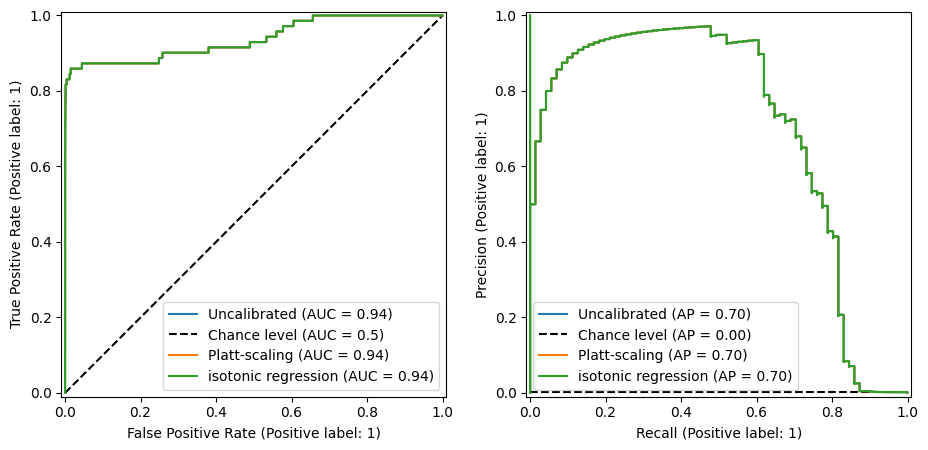

In [55]:

model_platt = CalibratedClassifierCV(
    model_1, 
    method='sigmoid',  # platt-sclaing: fitting a sigmoïd on top of the model
    cv='prefit'
)

model_iso = CalibratedClassifierCV(
    model_1, 
    method='isotonic',  # isotonic regression: fitting a constant-by-step function instead of a sigmoid
    cv='prefit'
)

model_platt.fit(X_cal, Y_cal)
model_iso.fit(X_cal, Y_cal)

Y_proba_1 = model_1.predict_proba(X_test)
Y_proba_platt = model_platt.predict_proba(X_test)
Y_proba_iso = model_platt.predict_proba(X_test)

fig, ax = plt.subplots(1, 2, figsize=(11,5))

RocCurveDisplay.from_predictions(
    Y_test,
    Y_proba_1[:, 1],
    ax=ax[0],
    name="Uncalibrated",
    plot_chance_level=True
)

PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_proba_1[:, 1],
    ax=ax[1],
    name="Uncalibrated",
    plot_chance_level=True
)

RocCurveDisplay.from_predictions(
    Y_test,
    Y_proba_platt[:, 1],
    ax=ax[0],
    name="Platt-scaling"
)

PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_proba_platt[:, 1],
    ax=ax[1],
    name="Platt-scaling"
)

RocCurveDisplay.from_predictions(
    Y_test,
    Y_proba_iso[:, 1],
    ax=ax[0],
    name="isotonic regression"
)

PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_proba_iso[:, 1],
    ax=ax[1],
    name="isotonic regression",
)

plt.show()

<div align="center">

**Figure - Receiver Operating Characteristic and Precision Recall for the uncalibrated and calibrated models**

Performances are the same for the uncalibrated and calibrated models, as the calibration doesn't change the ranking of the outputs.

</div>

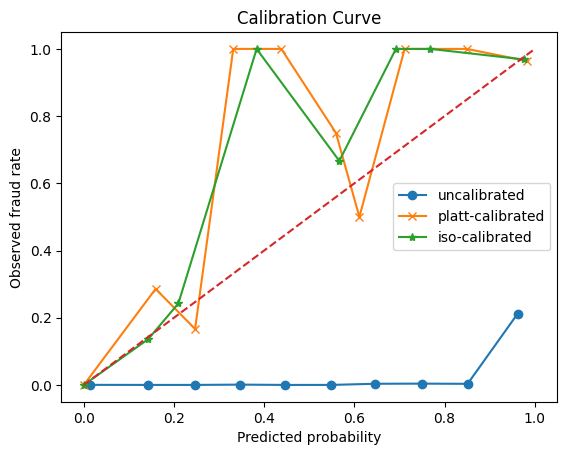

In [56]:
## Calibration curve

Y_proba_1 = model_1.predict_proba(X_test)
Y_proba_platt = model_platt.predict_proba(X_test)
Y_proba_iso = model_iso.predict_proba(X_test)

prob_true, prob_pred = calibration_curve(
    Y_test,
    Y_proba_1[:, 1],
    n_bins=10,
    strategy='uniform'
)

prob_true_platt, prob_pred_platt = calibration_curve(
    Y_test,
    Y_proba_platt[:, 1],
    n_bins = 10,
    strategy='uniform'
)

prob_true_iso, prob_pred_iso = calibration_curve(
    Y_test,
    Y_proba_iso[:, 1],
    n_bins = 10,
    strategy='uniform'
)

plt.plot(prob_pred, prob_true, marker='o', label='uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker='x', label='platt-calibrated')
plt.plot(prob_pred_iso, prob_true_iso, marker='*', label='iso-calibrated')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted probability")
plt.ylabel("Observed fraud rate")
plt.title("Calibration Curve")
plt.legend()
plt.show()

<div align="center">

**Figure - Calibration curve for the uncalibrated and calibrated models**

Calibration can only be approximate because of low samples and very well separated data.

</div>

## Threshold selection

As mentioned before, for data with high imbalance, keeping the default 0.5 threshold is rarely appropriate. In fraud detection, achieving a high recall generally requires accepting a substantial number of false positives, as fraudulent transactions do not all stand out clearly from genuine ones.
There are several strategies we can rely on to choose the threshold, most notably:  
- Minimum recall approach: "We owe our clients to catch at least X% of the frauds". This strategy is limited, as it doesn't take into account the cost of a low precision.  
- Cost function approach: "A false negative costs X, a false positive costs Y, what threshold minimizes the overall cost ?". This is a very reliable approach, granted you are able to estimate those costs correctly. This can be tricky, as the cost of mistakes includes a reputational cost on top of a monetary one. 
- Top K selection approach: if N agents can each go through M transactions during the day, then pick the K = M * N most suspicious transactions for verification.  

Each of these strategies emphasizes a different operational constraint, and they may all come in handy in different settings.   
  
To keep things simple, we adopt a cost-based approach with the following cost function for our threshold choice:  
  
$$C=20⋅FN+1⋅FP$$
  
This reflects the assumption that missing a fraudulent transaction is approximately twenty times more costly than raising a false alert. While this ratio is admittedly arbitrary —it could reasonably be set to 50 or even 100— the resulting optimal threshold is relatively stable.  
  
As you can see on the precision and recall plots below, there is a threshold below which the recall plateaus while the precision drops. To check wether the decision threshold depends strongly on the cost function used, let us plot of the cost function for different values of the relative cost between False Negatives and False Positives: 20, 50, 100. As you can see, the optimal threshold is right at the tipping point for all three cases.  
  
This robustness suggests that, despite the uncertainty in cost estimation, the chosen threshold captures a sensible trade-off between fraud detection effectiveness and operational burden.  
  
We can now confidently say that a threshold  around 0.01 for our model is optimal, and compute the corresponding performances on the test set: TPR = 77%, Precision = 50%.  
  
Again, those results are abnormally good because of the limited time span of the data set and its exceptional quality.

In [57]:
## Precision and Recall against threshold, w/wo calibration

Y_proba = model_1.predict_proba(X_test)
Y_proba_platt = model_platt.predict_proba(X_test)

precision, recall, thresholds = precision_recall_curve(Y_test, Y_proba[:, 1]) ## First column of Y_proba are probabilities for Class=0, second col Class=1
precision_cal, recall_cal, thresholds_cal = precision_recall_curve(Y_test, Y_proba_platt[:, 1]) ## First column of Y_proba are probabilities for Class=0, second col Class=1

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=thresholds,
    y=precision[:-1],
    mode="lines",
    name="Precision",
))

fig.add_trace(go.Scatter(
    x=thresholds,
    y=recall[:-1],
    mode="lines",
    name="Recall",
))

fig.update_layout(
    title="Precision & Recall vs Threshold, no calibration",
    xaxis_title="Threshold",
    yaxis_title="Score",
    hovermode="x unified",
)

fig.show()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=thresholds_cal,
    y=precision_cal[:-1],
    mode="lines",
    name="Precision",
))

fig.add_trace(go.Scatter(
    x=thresholds_cal,
    y=recall_cal[:-1],
    mode="lines",
    name="Recall",
))

fig.update_layout(
    title="Precision & Recall vs Threshold,  with Platt scaling calibration",
    xaxis_title="Threshold",
    yaxis_title="Score",
    hovermode="x unified",
)

fig.show()


<div align="center">

**Figure - Precision and Recall against threshold for uncalibrated and Platt-scaled models**

This plot makes the trade-off between recall and precision very obvious. For the uncalibrated model, you can see the recall plateau around 0.8 while the precision drops drastically. 

</div>

Optimal thresholds:
relative cost =  20  :  0.007
relative cost =  50  :  0.007
relative cost =  100  :  0.007


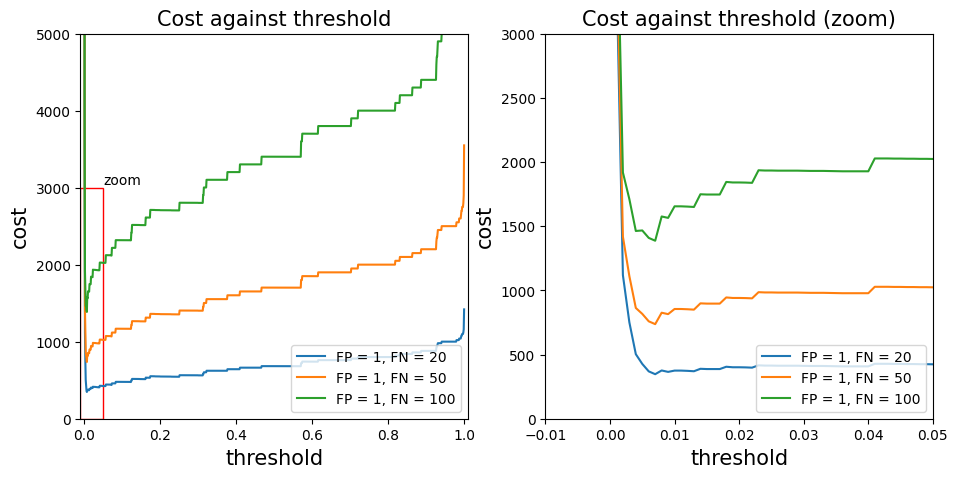

In [58]:
Y_proba_platt = model_platt.predict_proba(X_test)

cost_function, ax = plt.subplots(1, 2, figsize=(11,5))

print("Optimal thresholds:")
for relative_cost in [20, 50, 100]:
    thresholds, costs = plot_cost_function(relative_cost, 1, Y_test.to_list(), Y_proba_platt[:, 1], ax[0])
    thresholds, costs = plot_cost_function(relative_cost, 1, Y_test.to_list(), Y_proba_platt[:, 1], ax[1], title="Cost against threshold (zoom)")
    print("relative cost = ", relative_cost, " : ", thresholds[np.argmin(costs)])
    

ax[0].set_ylim(bottom=0, top=5000)
ax[1].set_ylim(bottom=0, top=3000)
ax[1].set_xlim(left = -0.01, right=0.05)

rect = Rectangle((-0.01, 0), 0.06, 3000, fill=False, edgecolor="red", linewidth=1)

ax[0].add_patch(rect)
_ = ax[0].text(0.05, 3000, "zoom", ha="left", va="bottom")



<div align="center">

**Figure - Cost function for different costs of False Negatives (undetected frauds)**

Though the cost functions are different, the optimal threshold always ends up right at the tipping point where the recall plateaus and the precision drops.

</div>

In [59]:
THRESHOLD = 0.01

Y_proba_platt = model_platt.predict_proba(X_test)

predicted_classes = classify(Y_proba_platt[:, 1], THRESHOLD)

TPR = compute_TPR(Y_test.to_list(), predicted_classes)
precision = compute_precision(Y_test.to_list(), predicted_classes)

print("Optimal threhsold: ", THRESHOLD)
print("TPR: ", TPR)
print("Precision: ", precision)

#with open("../models/model_lr_platt.pkl", "wb") as f:
#    pickle.dump(model_platt, f)



Optimal threhsold:  0.01
TPR:  0.7746478873239436
Precision:  0.5


## Logistic Regression — Conclusion  
  
Logistic Regression provides a strong baseline and serves as a useful framework to introduce time-aware splitting, appropriate evaluation metrics for class imbalance, probability calibration, and cost-based threshold selection.  
  
While the resulting ROC and PR performances appear very high, they should be interpreted cautiously given the limited temporal span of the dataset and the risk of learning dataset-specific patterns. This baseline establishes a solid reference point for evaluating a higher-capacity model in the next section.